### Template for NLP project

The aim of the project is to achieve the following:
 - Train a neural network that is **at least better than random guessing** on your dataset. The template contains the IMDB dataset for sentiment analysis, however, you can choose any other language related data set with the appropriate NLP task.
 - Investigate different neural network architectures (different hyperparameters, different layers, different pre-processing). Explain in the presentation, why the final network was selected! **Do not rely on black-box mechanisms.**
 

In [8]:
# tensorflow modules
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LayerNormalization, LSTM, Dropout
import tensorflow

# if you have installed a different version, replace 'r2.6'  with your version in links provided below
print(tensorflow.__version__)

2.8.0


In [9]:
# load imdb dataset
# links to dataset
# original dataset: https://ai.stanford.edu/~amaas/data/sentiment/
# version in tensorflow: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/datasets/imdb

# select your vocabulary size
vocabularySize = 5000
# load data (it is already pre-processed)
# optional: add other pre.processing steps like stopword removal
(xTrain, yTrain), (xTest, yTest) = imdb.load_data(num_words=vocabularySize)
print('Loaded dataset with {} training samples, {} test samples'.format(len(xTrain), len(xTest)))

# look at the data
print('---review---')
print(xTrain[123])
print('---label---')
print(yTrain[123])

# look at the respective words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in xTrain[123]])


# other related dataset already in tensorflow:  reuters newswire classification dataset
# see https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/datasets/reuters

Loaded dataset with 25000 training samples, 25000 test samples
---review---
[1, 307, 5, 1301, 20, 1026, 2511, 87, 2775, 52, 116, 5, 31, 7, 4, 91, 1220, 102, 13, 28, 110, 11, 6, 137, 13, 115, 219, 141, 35, 221, 956, 54, 13, 16, 11, 2714, 61, 322, 423, 12, 38, 76, 59, 1803, 72, 8, 2, 23, 5, 967, 12, 38, 85, 62, 358, 99]
---label---
1
---review with words---
['the', 'version', 'to', 'date', 'on', 'list', 'draw', 'him', 'critical', 'very', 'love', 'to', 'by', 'br', 'of', 'its', 'tony', 'characters', 'was', 'one', 'life', 'this', 'is', 'go', 'was', 'best', 'least', 'should', 'so', 'done', 'result', 'no', 'was', 'with', 'this', 'understood', 'only', 'war', "couldn't", 'that', 'her', 'get', 'would', 'johnny', 'we', 'in', 'and', 'are', 'to', 'business', 'that', 'her', 'because', 'story', 'use', 'movies']


In [10]:
# get properties of the dataset
print('Maximum train review length: {}'.format(len(max(xTrain, key=len))))
print('Maximum test review length: {}'.format(len(max(xTest, key=len))))
print('Minimum train review length: {}'.format(len(min(xTrain, key=len))))
print('Minimum test review length: {}'.format(len(min(xTest, key=len))))

Maximum train review length: 2494
Maximum test review length: 2315
Minimum train review length: 11
Minimum test review length: 7


In [11]:
# select maximum number of words as input lengt
# pad or truncated (this is done automatically) your data
maxWords = 1000
xTrain = sequence.pad_sequences(xTrain, maxlen=maxWords)
xTest = sequence.pad_sequences(xTest, maxlen=maxWords)

In [12]:
# setup the neural network architecture
# check out the respective tensorflow help page: https://www.tensorflow.org/guide/keras/rnn
model=Sequential()

# define size of embedding, see https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Embedding
# optional: use a different embedding like word2vec or other options available within tensorflow 
embeddingSize = 128
model.add(Embedding(vocabularySize, embeddingSize, input_length=maxWords))

# add recurrent layers: 
# e.g. a SimpleRNN (https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/SimpleRNN) with
# LayerNormalization (https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/LayerNormalization)

#model.add(SimpleRNN(100))

model.add(LSTM(64, return_sequences=True))
model.add(LayerNormalization())

model.add(LSTM(64, return_sequences=False))
model.add(LayerNormalization())

# add layer for output
model.add(Dense(1, activation='sigmoid'))

# print model and check number of parameters
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 128)         640000    
                                                                 
 lstm_2 (LSTM)               (None, 1000, 64)          49408     
                                                                 
 layer_normalization_2 (Laye  (None, 1000, 64)         128       
 rNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 layer_normalization_3 (Laye  (None, 64)               128       
 rNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                

In [13]:
# set parameters for network training
batchSize = 64
numEpochs = 5

# train your model
model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])
xValid, yValid = xTrain[:batchSize], yTrain[:batchSize]
xTrain2, yTrain2 = xTrain[batchSize:], yTrain[batchSize:]
hist = model.fit(xTrain2, yTrain2, validation_data=(xValid, yValid), batch_size=batchSize, epochs=numEpochs)

# check result
scores = model.evaluate(xTest, yTest, verbose=0)
print('Test accuracy:', scores[1])


model.save("model_lstm_norm_128")

Epoch 1/5


2022-06-07 19:40:10.212373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:40:10.735472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:40:13.297742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:40:16.246748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:40:23.847532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


390/390 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.7708

2022-06-07 19:44:47.676699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:44:47.791262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 19:44:50.219286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


390/390 [==============================] - 284s 672ms/step - loss: 0.4606 - accuracy: 0.7708 - val_loss: 0.2051 - val_accuracy: 0.9531
Epoch 2/5
390/390 [==============================] - 228s 583ms/step - loss: 0.2295 - accuracy: 0.9087 - val_loss: 0.1565 - val_accuracy: 0.9062
Epoch 3/5
390/390 [==============================] - 233s 597ms/step - loss: 0.1552 - accuracy: 0.9426 - val_loss: 0.1435 - val_accuracy: 0.9375
Epoch 4/5
390/390 [==============================] - 243s 623ms/step - loss: 0.1115 - accuracy: 0.9607 - val_loss: 0.1468 - val_accuracy: 0.9531
Epoch 5/5
390/390 [==============================] - 244s 626ms/step - loss: 0.0808 - accuracy: 0.9708 - val_loss: 0.0935 - val_accuracy: 0.9375


2022-06-07 20:00:41.424235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:00:41.602498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-07 20:00:44.323781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test accuracy: 0.7879200577735901


INFO:tensorflow:Assets written to: model_lstm_norm_128/assets


INFO:tensorflow:Assets written to: model_lstm_norm_128/assets


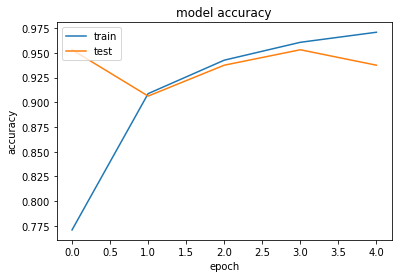

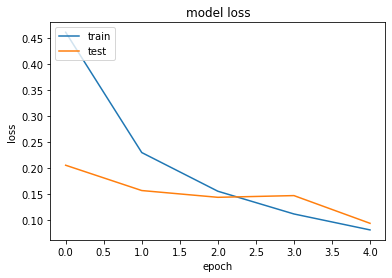

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()